#Colab 2: Learn to use Apache Spark with Python (25 points)

In this lab you will learn how to use Spark Dataframe, Spark SQL, and Spark RDD.

### **Setup**

Let's setup Spark on your Colab environment.  Run the cell below!

In [287]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u392-ga-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


Now we authenticate a Google Drive client to download files. Please follow the instruction to enter the authoriztion code.


In [288]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Now download the file we will be processing in our Spark job.

In [289]:
id='1il2RBIIMXaHXLg5H9oP-2fNCE10UZ-68'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('game-clicks.csv.gz')

id='1NQw0OQmY36xiFjYchIBrPNqr0tawxwCc'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('ad-clicks.csv.gz')


If you executed the cells above, you should be able to see the files under the "Files/content" folder on the left panel.

Import libraries.

In [290]:
import pandas as pd
import numpy as np
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Initialize the Spark context.


In [291]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

sc.stop()

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **Load `game-clicks` and `ad-clicks` datasets**



Load the datasets:

In [292]:
gameclicks = spark.read.csv("game-clicks.csv.gz", header='true')
adclicks = spark.read.csv("ad-clicks.csv.gz", header='true')

Check the schemas:

In [293]:
gameclicks.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- clickId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- userSessionId: string (nullable = true)
 |-- isHit: string (nullable = true)
 |-- teamId: string (nullable = true)
 |-- teamLevel: string (nullable = true)



In [294]:
adclicks.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- txId: string (nullable = true)
 |-- userSessionId: string (nullable = true)
 |-- teamId: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- adId: string (nullable = true)
 |-- adCategory: string (nullable = true)



Get a formatted sample with `show()`:

In [295]:
gameclicks.show()

+-------------------+-------+------+-------------+-----+------+---------+
|          timestamp|clickId|userId|userSessionId|isHit|teamId|teamLevel|
+-------------------+-------+------+-------------+-----+------+---------+
|2016-05-26 15:06:55|    105|  1038|         5916|    0|    25|        1|
|2016-05-26 15:07:09|    154|  1099|         5898|    0|    44|        1|
|2016-05-26 15:07:14|    229|   899|         5757|    0|    71|        1|
|2016-05-26 15:07:14|    322|  2197|         5854|    0|    99|        1|
|2016-05-26 15:07:20|     22|  1362|         5739|    0|    13|        1|
|2016-05-26 15:07:27|    107|  1071|         5939|    0|    27|        1|
|2016-05-26 15:07:30|    289|  2359|         5764|    0|    85|        1|
|2016-05-26 15:07:30|    301|  1243|         5900|    0|    86|        1|
|2016-05-26 15:07:47|    274|  1628|         5896|    0|    82|        1|
|2016-05-26 15:07:48|     66|   453|         5662|    0|    20|        1|
|2016-05-26 15:07:49|    124|  2336|  

Find the number of records:

In [296]:
print("In total there are {0} game clicks".format(gameclicks.count()))

print("In total there are {0} ad clicks".format(adclicks.count()))


In total there are 755806 game clicks
In total there are 16323 ad clicks


## **Question 1: How many users in each team?**
Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

Use [DataFrame API](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.html) to group the users by `teamID` and count how many distinct users in each team. Sort the result in descending order based on user counts. Note that your result in the last few rows might be different from the one shown below, because there exist multiple tuples of the same user counts.

In [297]:
team_counts = gameclicks.select("teamId", "userId").distinct().groupBy("teamId").count().sort(desc("count")).withColumnRenamed("count", "UserCount") # your code goes here (Q1a: 3 points)

team_counts.show()

+------+---------+
|teamId|UserCount|
+------+---------+
|    22|       33|
|    53|       26|
|    64|       25|
|    18|       25|
|    35|       23|
|    71|       21|
|    27|       21|
|    72|       21|
|    86|       21|
|    99|       20|
|    84|       20|
|     9|       20|
|    77|       19|
|    36|       19|
|    13|       19|
|    74|       19|
|    54|       18|
|    70|       18|
|   104|       18|
|    51|       18|
+------+---------+
only showing top 20 rows



# Now rewrite the above question using [Spark SQL](https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically):

In [298]:
gameclicks.registerTempTable("gameclicks")

query = ''' SELECT teamId, COUNT(DISTINCT userId) AS UserCount
            FROM gameclicks
            GROUP BY teamId
            ORDER BY UserCount DESC '''  # your code goes here (Q1b: 2 points)

team_counts = spark.sql(query)
team_counts.show()

+------+---------+
|teamId|UserCount|
+------+---------+
|    22|       33|
|    53|       26|
|    64|       25|
|    18|       25|
|    35|       23|
|    71|       21|
|    27|       21|
|    72|       21|
|    86|       21|
|    99|       20|
|    84|       20|
|     9|       20|
|    77|       19|
|    36|       19|
|    13|       19|
|    74|       19|
|    54|       18|
|    70|       18|
|   104|       18|
|    51|       18|
+------+---------+
only showing top 20 rows



##The `team_counts` Dataframe is small enough to be moved to Pandas:

In [299]:
team_counts_pd = team_counts.toPandas()
team_counts_pd.head()

,teamId,UserCount
0,22,33
1,53,26
2,64,25
3,18,25
4,35,23


##[Plot](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html) a histogram using the data above:

Use the data above to plot a histogram of 10 equal-width bins where the x-axis shows the number of users and the y-axis shows the number of teams. Your output doesn't need to match exactly to the output below, but you need to add the x-label, the y-label and the title to the graph.

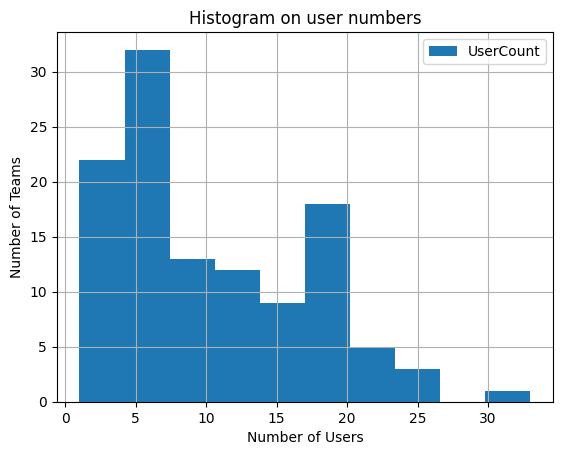

In [315]:
# your code goes here (Q1c: 3 points)
import matplotlib.pyplot as plt

team_counts_pd.hist(bins = 10)
plt.title("Histogram on user numbers")
plt.ylabel('Number of Teams')
plt.xlabel('Number of Users')
plt.legend(['UserCount']);

----

## **Questions 2: Now use the `ad-clicks` dataset to find the number of ad clicks in each individual hour.**

Keywords: `group by`, `parse timestamp`, `plot`

In [301]:
timestamp_only = adclicks.selectExpr(["to_timestamp(timestamp) as timestamp"])

click_count_by_hour =  adclicks.select(hour('timestamp').alias('hour'), 'userId').groupBy('hour').count().sort(asc('hour')) # your code goes here (Q2a: 3 points)

click_count_by_hour.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0|  605|
|   1|  728|
|   2|  633|
|   3|  552|
|   4|  614|
|   5|  691|
|   6|  710|
|   7|  704|
|   8|  726|
|   9|  799|
|  10|  705|
|  11|  648|
|  12|  714|
|  13|  647|
|  14|  623|
|  15|  695|
|  16|  707|
|  17|  662|
|  18|  686|
|  19|  603|
|  20|  675|
|  21|  756|
|  22|  696|
|  23|  744|
+----+-----+



# Use line plot to show the number of clicks by hour:

<Figure size 640x480 with 0 Axes>

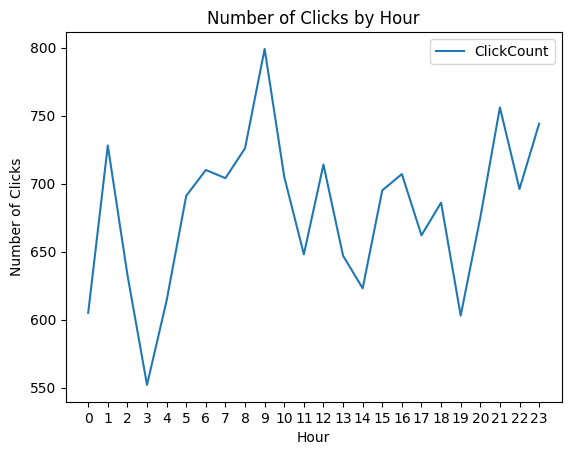

In [319]:
click_by_hour_pd = click_count_by_hour.toPandas()

# your code goes here (Q2b: 3 points)
plt.figure()
click_by_hour_pd.plot('hour', 'count')
plt.title("Number of Clicks by Hour")
plt.ylabel('Number of Clicks')
plt.xlabel('Hour')
plt.legend(['ClickCount'])
plt.xticks(range(0, 24));

## Question 3: Use `map` and `reduceByKey` with RDD

Keywords: `RDD map reduceByKey`

Now we want to find the number of clicks of each `adCategorory` using `map` and `reduceByKey` with RDD. Since we only care the `adCategory`, let's select this column only.

In [303]:
categoryOnly = adclicks.select("adCategory")
categoryOnly.show(10)


+-----------+
| adCategory|
+-----------+
|electronics|
|     movies|
|  computers|
|    fashion|
|   clothing|
|      games|
|     movies|
|electronics|
|electronics|
|  computers|
+-----------+
only showing top 10 rows



First we emit a pair in the format (`adCategory`, 1) by using a `map()` function:

In [304]:
all_categories = categoryOnly.rdd.map(lambda x: (x, 1)) # your code goes here (Q3a: 3 points)
all_categories.take(5)

[(Row(adCategory='electronics'), 1),
 (Row(adCategory='movies'), 1),
 (Row(adCategory='computers'), 1),
 (Row(adCategory='fashion'), 1),
 (Row(adCategory='clothing'), 1)]

Then, sum the number by using a `reduceByKey()` function. Afterwards, sort by counts in descending order:

In [305]:
from operator import add
category_counts_rdd = all_categories.reduceByKey(add).sortBy(lambda x: x[1], ascending = False) # your code goes here (Q3b: 3 points)
category_counts_rdd.take(3)

[(Row(adCategory='computers'), 2638),
 (Row(adCategory='games'), 2601),
 (Row(adCategory='clothing'), 2340)]

Next, convert the `category_counts_rdd` [to a dataframe](https://sparkbyexamples.com/pyspark/convert-pyspark-rdd-to-dataframe/) `category_counts_df`.

In [324]:
category_counts_df = spark.createDataFrame(category_counts_rdd, ["adCategory", "ClickCount"]) # your code goes here (Q3c: 3 points)
category_counts_df.show()

+-------------+----------+
|   adCategory|ClickCount|
+-------------+----------+
|  {computers}|      2638|
|      {games}|      2601|
|   {clothing}|      2340|
|     {sports}|      2074|
|    {fashion}|      1727|
|     {movies}|      1692|
|   {hardware}|      1588|
|{electronics}|      1097|
| {automotive}|       566|
+-------------+----------+



Finally, use Spark SQL to verify the above result:

In [323]:
#print(adclicks.count())

adclicks.registerTempTable("adclicks")

query = ''' SELECT adCategory, COUNT(adCategory) AS ClickCount
            FROM adclicks
            GROUP BY adCategory
            ORDER BY ClickCount DESC ''' # your code goes here (Q3d: 2 point)

category_counts = spark.sql(query)
category_counts.show()


+-----------+----------+
| adCategory|ClickCount|
+-----------+----------+
|  computers|      2638|
|      games|      2601|
|   clothing|      2340|
|     sports|      2074|
|    fashion|      1727|
|     movies|      1692|
|   hardware|      1588|
|electronics|      1097|
| automotive|       566|
+-----------+----------+



#Congratulations on the second Spark assignment!